# TD Lambda + Tile Coding for Heartbeat prediction

Import libraries: numpy, tile_coding

tile_coding is our own library to be used as a linear approximation function.

In [1]:
import numpy as np
from tile_coding import *

## 1. TD Lambda with tile coding for nexting

* What we need more for this part

1.We need to reconsider the reward function.


2.Hyperparameters?

In [79]:
class Nexting:
    
    def __init__(self, reward_batch=1, exp_rate=0.1, lmbda=0.4, debug=True):
        self.actions = [-1, 0, 1]  # lower, 0 and upper beat
        self.state = (0,0)  # current heartbeat, predicted amount of change
        self.exp_rate = exp_rate
        self.end = False
        self.lmbda = lmbda
        self.rate_truncate = 1e-3
        self.reward_batch = reward_batch
        self.debug = debug
        self.step_num = 0
        
    def reset(self):
        pos = np.random.uniform(-0.3, 0.4) #?min max
        self.end = False
        self.state = (pos, 0)
        self.step_num = 0
        
    def takeAction(self, action):
        pos, gap = self.state
        
        #gap_new = gap + 0.001*action - 0.0025*np.cos(3*pos) #?
        gap_new = gap + 0.001*action
        gap_new = min(max(gap_new, GAP_BOUND[0]), GAP_BOUND[1])
        
        pos_new = pos + gap_new
        pos_new = min(max(pos_new, POSITION_BOUND[0][0]), POSITION_BOUND[0][1]) # need to change
        
        if pos_new == POSITION_BOUND[0][0]: #?
            #reach leftmost, set gap to 0
            gap_new = 0.005 # non zero
            
        elif pos_new == POSITION_BOUND[0][1]:
            gap_new = -0.005
             
        self.state = (pos_new, gap_new)
        
        return self.state ###
    
    def chooseAction(self, valueFunc):
        # choose an action based on the current state, 
        if np.random.uniform(0, 1) <= self.exp_rate:
            # random action
            return np.random.choice(self.actions)
        else:
            # greedy action
            values = {}
            for a in self.actions:
                value = valueFunc.value(self.state, a)
                values[a] = value
            return np.random.choice([k for k, v in values.items() if v==max(values.values())])
        
    def giveReward(self): # ***
        
        self.step_num += 1
        
        if self.step_num >= len(data):
            self.step_num = len(data) - 1
        
        if self.step_num % self.reward_batch == 0:
            pos, _ = self.state
            true_pos = data[self.step_num]
            
            if pos >= true_pos - 0.01 and pos <= true_pos + 0.01:
                return 0
        
        if self.step_num == len(data) - 1:
            self.end = True
        
        return -1
    
    def gt2tn(self, valueFunc, action, end):
        # only the last reward is non-zero
        reward = self.reward
        res = reward + valueFunc.value(self.state, action)
        
        return res
        
    def play(self, valueFunction, rounds=1):
        states_per_rounds = []
        
        for rnd in range(rounds):
            self.reset()
            action = self.chooseAction(valueFunction)
            
            actions = [action]
            states = [self.state]
            rewards = [-1]
            
            while not self.end:
                self.state = self.takeAction(action)  # next state
                self.reward = self.giveReward()
                
                states.append(self.state)
                action = self.chooseAction(valueFunction)
                
                if self.step_num % self.reward_batch == 0:
                    if self.debug:
                        print("total states {} end at {} reward {}".format(len(states), self.state, self.reward))
                        
                    T = len(states) - 1
                    
                    for t in range(T):
                        state = states[t]
                        gtlambda = 0
                        
                        for n in range(1, T-t):
                            gttn = self.gt2tn(valueFunction, action, t+n)
                            lambda_power = np.power(self.lmbda, n-1)
                            gtlambda += lambda_power*gttn
                            
                            if lambda_power < self.rate_truncate:
                                break
                                
                        gtlambda *= 1 - self.lmbda
                        
                        if lambda_power >= self.rate_truncate:
                            gtlambda += lambda_power*self.reward
                            
                        delta = gtlambda - valueFunction.value(self.state, action)
                        valueFunction.update(self.state, action, delta)
            
            states_per_rounds.append(states)
            
        return states_per_rounds

## 2. Loading the dataset

Please run the cell below if you don't have neurokit2 and mne as your python libraries. In case you have these two, you don't need to run the cell.

In [ ]:
!pip install neurokit2
!pip install mne

In [3]:
import pandas as pd
from sklearn.preprocessing import normalize
import neurokit2 as nk
import mne
import matplotlib.pyplot as plt

In [4]:
file = "data/r04.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# after normalization 
raw_data = normalize(raw_data,axis=1,norm="max")
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

# cleanup the data
for i in range(len(raw_data)):
    raw_data[i] = nk.ecg_clean(raw_data[i],method="neurokit")

# feature range
POSITION_BOUND = [] #? range of heartbeat
for i in range(len(raw_data)):
    POSITION_BOUND.append([min(raw_data[i]), max(raw_data[i])])

Extracting EDF parameters from /Users/Textory/Desktop/Fall2022/cmput655/data/r04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


# 3. Settings to run TD lambda model for the dataset

* What we need more for this part

1.The experiment here is only for the first row of the dataset. We can use a simple loop for applying the model to our entire dataset.


2.We need to implement a progress bar of the model.


3.We need to change some hyper parameters.

In [ ]:
data = raw_data[0]
GAP_BOUND = [-0.01, 0.01] #?
ACTIONS = [-1, 0, 1]
reward_batch = 300

feature_ranges = [POSITION_BOUND[0], GAP_BOUND]  # 2 features
number_tilings = 8
bins = [[100, 100] for _ in range(number_tilings)]
offsets = [[i, j] for i, j in zip(np.linspace(POSITION_BOUND[0][0], POSITION_BOUND[0][1], number_tilings), np.linspace(GAP_BOUND[0], GAP_BOUND[1], number_tilings))]

tilings = createTilings(feature_ranges, number_tilings, bins, offsets)

print("tiling shape: \n", tilings.shape)
print("offsets: \n", offsets)

valueFunc = qvalueFunction(tilings, ACTIONS, 0.3)

mc = Nexting(reward_batch=reward_batch)
predicted_states = mc.play(valueFunc, rounds=1)

tiling shape: 
 (8, 2, 99)
offsets: 
 [[-0.3326277028214003, -0.01], [-0.22827675655421997, -0.0071428571428571435], [-0.12392581028703961, -0.004285714285714286], [-0.01957486401985925, -0.0014285714285714284], [0.08477608224732108, 0.0014285714285714284], [0.18912702851450147, 0.004285714285714285], [0.2934779747816818, 0.0071428571428571435], [0.39782892104886214, 0.01]]
total states 301 end at (-0.22717107895113825, 0.001) reward -1
total states 601 end at (0.260828921048862, -0.01) reward -1
total states 901 end at (-0.28062770282140026, 0.003) reward -1
total states 1201 end at (-0.19062770282140018, -0.006) reward -1
total states 1501 end at (-0.07262770282140008, 0.007) reward -1
total states 1801 end at (-0.24462770282140023, 0.007) reward -1
total states 2101 end at (0.39482892104886214, 0.008) reward -1
total states 2401 end at (0.10237229717859996, -0.001) reward -1
total states 2701 end at (0.08837229717859994, 0.006) reward -1
total states 3001 end at (0.09037229717859994

total states 36001 end at (-0.29262770282140027, -0.002) reward -1
total states 36301 end at (0.31782892104886207, -0.01) reward -1
total states 36601 end at (-0.2226277028214002, 0.007) reward -1
total states 36901 end at (0.3053722971786001, 0.003) reward -1
total states 37201 end at (0.18582892104886195, -0.01) reward -1
total states 37501 end at (-0.2006277028214002, 0.006) reward -1
total states 37801 end at (-0.16562770282140016, 0.007) reward -1
total states 38101 end at (0.29582892104886205, 0.001) reward -1
total states 38401 end at (-0.13462770282140013, 0.009000000000000001) reward -1
total states 38701 end at (-0.19217107895113816, -0.009000000000000001) reward -1
total states 39001 end at (0.15037229717859998, 0.01) reward -1
total states 39301 end at (0.06782892104886193, -0.009000000000000001) reward -1
total states 39601 end at (-0.3096277028214003, 0.006) reward -1
total states 39901 end at (0.07337229717859993, 0.006) reward -1
total states 40201 end at (0.00237229717

total states 72601 end at (-0.05862770282140007, 0.005) reward -1
total states 72901 end at (-0.0946277028214001, 0.002) reward -1
total states 73201 end at (-0.10162770282140007, -0.001) reward -1
total states 73501 end at (-0.15062770282140012, -0.001) reward -1
total states 73801 end at (-0.13817107895113812, -0.009000000000000001) reward -1
total states 74101 end at (-0.2361710789511383, -0.008) reward -1
total states 74401 end at (0.18882892104886195, -0.002) reward -1
total states 74701 end at (0.11782892104886189, 0.0) reward -1
total states 75001 end at (-0.1016277028214001, 0.006) reward -1
total states 75301 end at (0.27237229717860006, 0.003) reward -1
total states 75601 end at (-0.15862770282140015, -0.002) reward -1
total states 75901 end at (0.29782892104886205, -0.005) reward -1
total states 76201 end at (-0.15862770282140015, -0.001) reward -1
total states 76501 end at (-0.2266277028214001, -0.009000000000000001) reward -1
total states 76801 end at (-0.2156277028214002,

total states 110101 end at (-0.21717107895113827, -0.003) reward -1
total states 110401 end at (-0.10962770282140011, -0.001) reward -1
total states 110701 end at (-0.17562770282140017, -0.001) reward -1
total states 111001 end at (0.28682892104886204, -0.003) reward -1
total states 111301 end at (0.27982892104886203, -0.005) reward -1
total states 111601 end at (0.3708289210488621, -0.003) reward -1
total states 111901 end at (0.3508289210488621, -0.001) reward -1
total states 112201 end at (0.39382892104886214, 0.002) reward -1
total states 112501 end at (0.3438289210488621, -0.006) reward -1
total states 112801 end at (-0.18817107895113827, 0.0) reward -1
total states 113101 end at (0.3388289210488621, 0.0) reward -1
total states 113401 end at (0.27382892104886203, -0.002) reward -1
total states 113701 end at (0.3358289210488621, -0.003) reward -1
total states 114001 end at (0.2878289210488621, 0.001) reward -1
total states 114301 end at (0.3788289210488621, -0.004) reward -1
total 

total states 147001 end at (0.3778289210488621, -0.007) reward -1
total states 147301 end at (0.2693722971786, 0.01) reward -1
total states 147601 end at (-0.19162770282140018, 0.007) reward -1
total states 147901 end at (0.06082892104886189, -0.009000000000000001) reward -1
total states 148201 end at (-0.2966277028214003, 0.001) reward -1
total states 148501 end at (-0.16117107895113822, -0.003) reward -1
total states 148801 end at (-0.28317107895113824, -0.006) reward -1
total states 149101 end at (0.39782892104886214, -0.005) reward -1
total states 149401 end at (0.251828921048862, 0.001) reward -1
total states 149701 end at (-0.27262770282140025, 0.0) reward -1
total states 150001 end at (0.3358289210488621, 0.002) reward -1
total states 150301 end at (0.269828921048862, -0.006) reward -1
total states 150601 end at (0.28982892104886204, 0.001) reward -1
total states 150901 end at (-0.010627702821400069, 0.004) reward -1
total states 151201 end at (0.269828921048862, 0.005) reward -

total states 183301 end at (0.35637229717860014, 0.007) reward -1
total states 183601 end at (0.27682892104886203, -0.004) reward -1
total states 183901 end at (0.2643722971786001, 0.002) reward -1
total states 184201 end at (0.36037229717860014, 0.0) reward -1
total states 184501 end at (0.060372297178599904, 0.003) reward -1
total states 184801 end at (0.3003722971786001, 0.007) reward -1
total states 185101 end at (0.035828921048861845, -0.008) reward -1
total states 185401 end at (-0.27562770282140026, 0.007) reward -1
total states 185701 end at (-0.3066277028214003, 0.007) reward -1
total states 186001 end at (-0.3166277028214003, -0.01) reward -1
total states 186301 end at (-0.24217107895113835, -0.003) reward -1
total states 186601 end at (-0.2116277028214002, 0.002) reward -1
total states 186901 end at (0.18882892104886195, -0.01) reward -1
total states 187201 end at (0.14682892104886192, -0.004) reward -1
total states 187501 end at (0.3598289210488621, 0.003) reward -1
total s

total states 219901 end at (-0.18462770282140017, -0.001) reward -1
total states 220201 end at (-0.029627702821400086, -0.007) reward 0
total states 220501 end at (0.17637229717860006, 0.002) reward -1
total states 220801 end at (0.20182892104886196, 0.007) reward -1
total states 221101 end at (-0.1101710789511382, 0.001) reward -1
total states 221401 end at (0.11282892104886191, 0.0) reward -1
total states 221701 end at (0.0928289210488619, 0.002) reward -1
total states 222001 end at (0.186828921048862, 0.008) reward -1
total states 222301 end at (0.09182892104886191, -0.001) reward -1
total states 222601 end at (0.009828921048861898, 0.001) reward -1
total states 222901 end at (0.07782892104886195, 0.002) reward -1
total states 223201 end at (0.006828921048861993, -0.001) reward -1
total states 223501 end at (-0.03917107895113819, -0.003) reward -1
total states 223801 end at (-0.27162770282140025, 0.0) reward -1
total states 224101 end at (-0.18862770282140026, -0.002) reward -1
tota

total states 256801 end at (0.06937229717859994, 0.006) reward 0
total states 257101 end at (0.01682892104886191, -0.009000000000000001) reward -1
total states 257401 end at (0.07537229717859992, 0.001) reward -1
total states 257701 end at (0.255828921048862, 0.001) reward -1
total states 258001 end at (-0.09562770282140015, -0.005) reward -1
total states 258301 end at (0.09037229717859994, 0.005) reward -1
total states 258601 end at (-0.08217107895113819, -0.004) reward -1
total states 258901 end at (0.051372297178599924, 0.004) reward -1
total states 259201 end at (0.17637229717860003, 0.006) reward -1
total states 259501 end at (0.07037229717859993, -0.001) reward -1
total states 259801 end at (-0.10817107895113819, 0.0) reward -1
total states 260101 end at (-0.13517107895113822, -0.002) reward -1
total states 260401 end at (0.1013722971785999, 0.004) reward -1
total states 260701 end at (-0.12362770282140012, -0.004) reward -1
total states 261001 end at (-0.12717107895113822, -0.00

## 4. Visualisation

* What we need more for this part

1.We need to draw a graphs to compare real heartbeat / predicted heartbeat values.

### Comparing between true data and predicted results

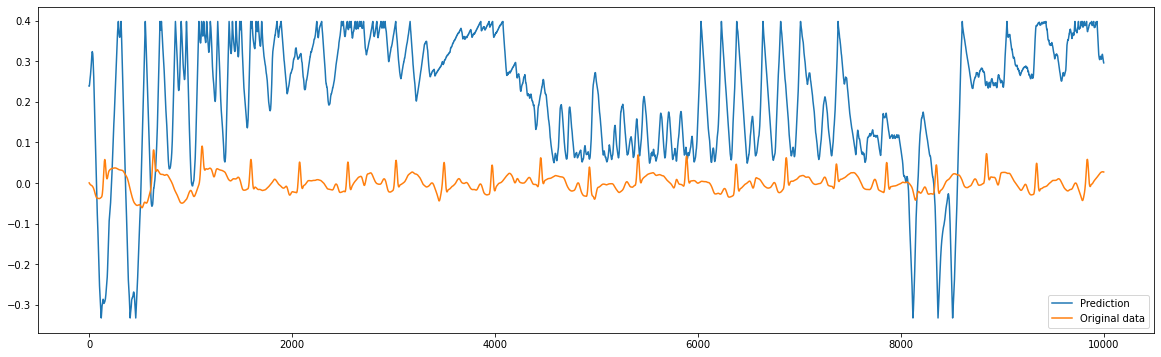

In [74]:
grids = len(data)
time_step = np.linspace(1, len(data), len(data))

for i in range(len(predicted_states)):
    predicted_position = []
    
    for j in range(len(data)):
        predicted_position.append(predicted_states[i][j][0])
    
    plt.figure(figsize=(20,6))
    plt.plot(time_step, predicted_position, label = "Prediction")
    plt.plot(time_step, data, label = "Original data")
    plt.legend()
    plt.show()
    
#linestyle=":"

### RMSE Prop

In [75]:
import math

start = 0
end = 0
RMSE_value = []

for i in range(1, len(data)):
    
    if i % reward_batch == 0:
        
        start = end
        end = end + reward_batch
        
        true_batch = data[:end]
        predict_batch = predicted_position[:end]
        
        MSE = np.square(np.subtract(true_batch,predict_batch)).mean()
        RMSE = math.sqrt(MSE)
        
        RMSE_value.append(RMSE)
        

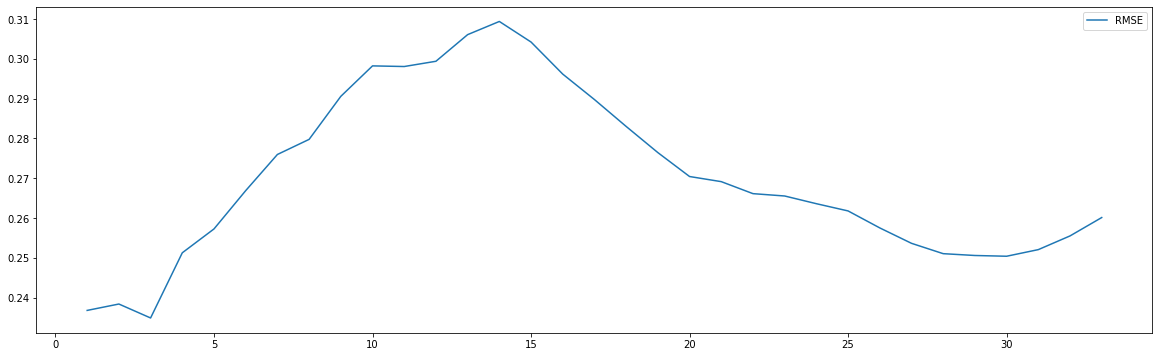

In [76]:
grids = len(RMSE_value)
step = np.linspace(1, len(RMSE_value), len(RMSE_value))

plt.figure(figsize=(20,6))
plt.plot(step, RMSE_value, label = "RMSE")

plt.legend()
plt.show()

### Cost graph

Text(0.5, 0, 'Cost')

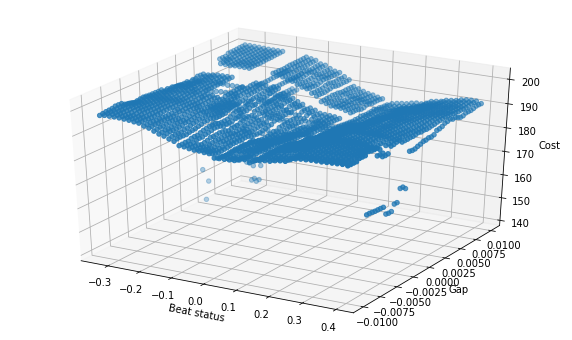

In [135]:
grids = 50

positions = np.linspace(POSITION_BOUND[0][0], POSITION_BOUND[0][1], grids)
vels = np.linspace(GAP_BOUND[0], GAP_BOUND[1], grids)

x = []
y = []
z = []
for p in positions:
    for v in vels:
        x.append(p)
        y.append(v)
        z.append(valueFunc.stepcost([p, v]))

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel("Beat status")
ax.set_ylabel("Gap")
ax.set_zlabel("Cost")